# Random Forest sur le jeu de données mfeat

**Description**  
On dispose de 2000 images décrites par 6 ensembles d’indicateurs (coefficients de Fourier, profil de corrélations, coefficients de Karhunen-Love, valeurs des pixels moyennés, moments de Zernike, morphologie). Chacune de ces images représente un chiffre manuscrit. Une description des données est disponible [ici](https://archive.ics.uci.edu/ml/datasets/Multiple+Features).

Quelques liens pour comprendre la signification des variables:  

* Série de Fourier: http://maths.cnam.fr/Didacticiels/Sur_Le_Traitement_Du_Son/coinmath.htm  


* Coefficient de Karhunen-Love: http://www.tsi.enst.fr/pages/enseignement/ressources/mti/KL/site/principe_KL.html  


* Pour les pixels : https://images.math.cnrs.fr/Le-traitement-numerique-des-images.html?lang=fr  

##### RUBRIQUES

[IMPORTS](#imports)  


[REGLAGES DU NOTEBOOK](#reglages)  

[IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES](#import_check)  

[ANALYSE UNIVARIÉE ET BIVARIÉE](#analyse_exploratoire_uni_bi)  

[SÉPARATION DU JEU DE DONNÉES: TRAIN vs VAL](#separation_data)  

[RANDOM FOREST](#rf)  

[REQUIREMENTS.txt](#requirements)

### <a id="imports" style="color:black">IMPORTS</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

np.random.seed(2020)

### <a id="reglages" style="color:black">REGLAGES DU NOTEBOOK</a>

In [2]:
## Nombre de lignes/colonnes que Pandas peut afficher dans le notebook
pd.set_option('display.max_rows', 200)
#pd.set_option('display.max_columns', 500)


## Hauteur/largeur maximale des cellules que Pandas peut afficher dans le notebook sans tronquer
#pd.set_option('display.width', 1000)


## Affichage des nombres à virgule en gardant seulement 5 chiffres après la virgule
pd.set_option('display.float_format', lambda x: '%.5f' % x)


## Nombre d'éléments max qu'on peut afficher dans un array + suppression de notation scientifique
np.set_printoptions(threshold=200,suppress=True)

## <a id="import_check" style="color:black">IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES</a>


In [3]:
df_train = pd.read_csv("../data/csv-txt/mfeat/data_train.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 650 entries, fac_1 to class
dtypes: float64(190), int64(460)
memory usage: 7.4 MB


In [5]:
df_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [6]:
# Mettre la variable 'class' en string
df_train["class"] = df_train["class"].astype(str)

In [7]:
df_train.dtypes

fac_1       int64
fac_2       int64
fac_3       int64
fac_4       int64
fac_5       int64
           ...   
zer_44    float64
zer_45    float64
zer_46    float64
zer_47    float64
class      object
Length: 650, dtype: object

In [8]:
df_train["class"].describe()

count     1500
unique      10
top          0
freq       150
Name: class, dtype: object

In [9]:
df_train.head()

,fac_1,fac_2,fac_3,fac_4,fac_5,fac_6,fac_7,fac_8,fac_9,fac_10,...,zer_39,zer_40,zer_41,zer_42,zer_43,zer_44,zer_45,zer_46,zer_47,class
0,182,192,575,657,650,702,1,9,5,6,...,30.37704,8.13780,4.24529,179.84887,331.68767,8.04001,16.30939,53.62373,487.26241,0
1,97,185,530,688,603,688,3,6,5,4,...,55.36354,41.25013,4.92292,183.83757,324.73343,15.40222,54.79385,57.74679,554.88999,0
2,135,207,630,685,578,599,8,9,7,3,...,7.68219,22.56606,9.17687,201.46880,535.09909,1.78629,15.74437,57.65181,643.78864,0
3,265,277,720,728,630,674,15,9,9,7,...,14.27184,8.58904,13.33504,172.97290,273.34529,3.30595,7.34407,52.91831,406.85680,0
4,134,164,614,618,618,656,2,8,1,6,...,15.24173,34.62034,7.06070,172.17341,321.38851,4.24516,16.98600,53.95255,521.36401,0


In [10]:
# Vérification doublons parfaits
df_train[df_train.duplicated(keep=False)]

,fac_1,fac_2,fac_3,fac_4,fac_5,fac_6,fac_7,fac_8,fac_9,fac_10,...,zer_39,zer_40,zer_41,zer_42,zer_43,zer_44,zer_45,zer_46,zer_47,class
453,269,223,847,701,661,685,21,11,11,15,...,26.87227,84.09126,5.03149,207.56780,320.71647,6.28303,48.47966,61.95319,484.79816,3
518,269,223,847,701,661,685,21,11,11,15,...,26.87227,84.09126,5.03149,207.56780,320.71647,6.28303,48.47966,61.95319,484.79816,3
850,243,145,693,686,676,705,11,12,15,10,...,16.24987,48.56092,6.95441,219.34079,391.89752,3.23090,26.04288,66.28172,563.51089,5
876,243,145,693,686,676,705,11,12,15,10,...,16.24987,48.56092,6.95441,219.34079,391.89752,3.23090,26.04288,66.28172,563.51089,5
1065,416,424,845,959,687,809,34,27,27,11,...,49.57449,70.40772,12.27030,229.56143,261.43384,12.85473,95.37960,67.03341,381.23656,7
1145,416,424,845,959,687,809,34,27,27,11,...,49.57449,70.40772,12.27030,229.56143,261.43384,12.85473,95.37960,67.03341,381.23656,7


In [11]:
## Suppression des doublons parfaits
df_train.drop_duplicates(inplace=True)

In [12]:
df_train.shape

(1497, 650)

### <a id="analyse_exploratoire_uni_bi" style="color:black">ANALYSE UNIVARIÉE ET BIVARIÉE</a>

Voir fichier 'acp mfeat' pour l'analyse exploratoire détaillée

### <a id="separation_data" style="color:black">SÉPARATION DU JEU DE DONNÉES: TRAIN vs VAL</a>

In [13]:
X = df_train.iloc[:, :-1].values
y = df_train.iloc[:, -1].values

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3333, stratify=y)

In [15]:
np.unique(y_val, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([50, 50, 50, 50, 50, 49, 50, 50, 50, 50], dtype=int64))

## <a id="rf" style="color:black">Random Forest</a>

In [18]:
# 1. Données non modifiées

rf1 = RandomForestClassifier(n_estimators = 100, random_state=2020)
rf1.fit(X_train, y_train)

rf_pred1 = rf1.predict(X_val)

rf_err1 = 1.0 - metrics.accuracy_score(y_val,rf_pred1)

print('Accuracy:', metrics.accuracy_score(y_val,rf_pred1))
print('Error:', rf_err1)

0.01603206412825653


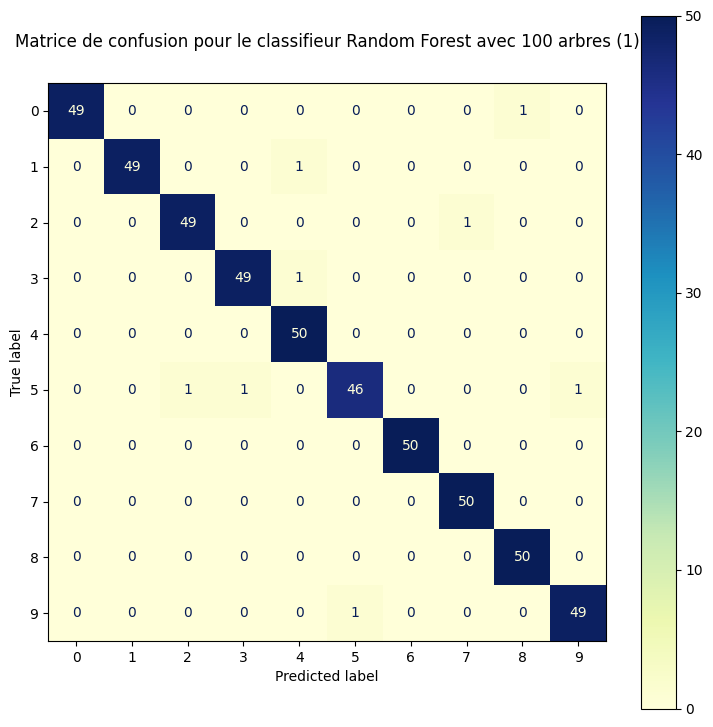

In [19]:
# Matrice de confusion
_, ax = plt.subplots(figsize=(9, 9))

mat_sc = metrics.plot_confusion_matrix(rf1, X_val, y_val, cmap="YlGnBu", ax=ax)
plt.title("Matrice de confusion - Random Forest avec 100 arbres (1)", y=1.05)
plt.show()

In [20]:
# 2. Données non modifiées + tuning

rf2 = RandomForestClassifier(random_state=2020)

rf_params_grid = {"max_depth": [80, 90, 100, 110], 'n_estimators': (100, 200, 300, 400, 500)}
grid_rf1 = GridSearchCV(rf2, param_grid=rf_params_grid, scoring="accuracy", refit = True, verbose=2) 

grid_rf1.fit(X_train, y_train) 

print("\n======================================================\n")

print(grid_rf1.best_params_) 
print(grid_rf1.best_estimator_) 




{'max_depth': 80, 'n_estimators': 500}
RandomForestClassifier(max_depth=80, n_estimators=500, random_state=2020)


In [21]:
rf_pred2 = grid_rf1.predict(X_val)

rf_err2 = 1.0 - metrics.accuracy_score(y_val,rf_pred2)

print('Accuracy:', metrics.accuracy_score(y_val,rf_pred2))
print('Error:', rf_err2)

0.01002004008016033


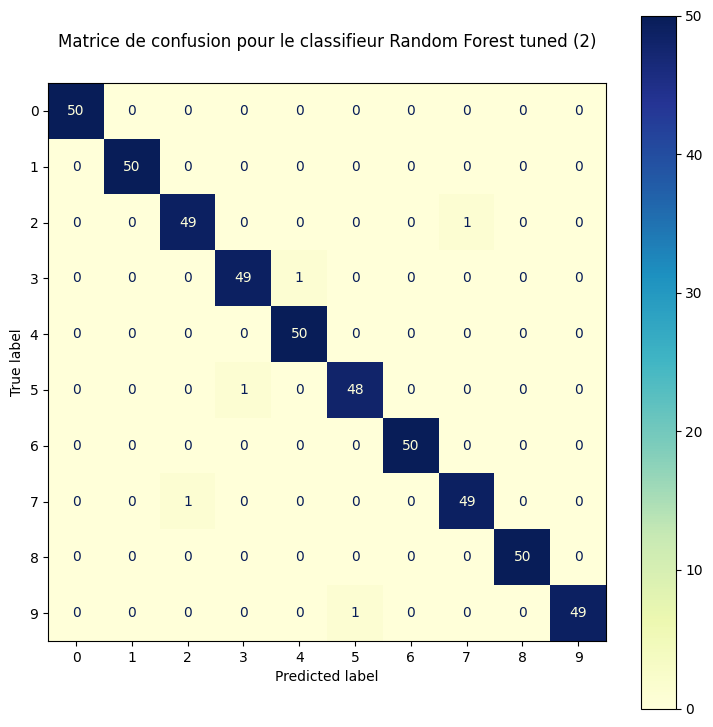

In [23]:
# Matrice de confusion
_, ax = plt.subplots(figsize=(9, 9))

mat_sc = metrics.plot_confusion_matrix(grid_rf1, X_val, y_val, cmap="YlGnBu", ax=ax)
plt.title("Matrice de confusion - Random Forest tuned (2)", y=1.05)
plt.show()

### Entrainement et prédiction sur données centrée-réduites

In [24]:
# Standardisation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

X_train_sc, X_val_sc, y_train_sc, y_val_sc = train_test_split(X_sc, y, test_size = 0.3333, stratify=y)

In [25]:
# 3. Données standardisées + tuning

rf3 = RandomForestClassifier(random_state=2020)

rf_params_grid = {"max_depth": [80, 90, 100, 110], 'n_estimators': (100, 200, 300, 400, 500)}
grid_rf2 = GridSearchCV(rf3, param_grid=rf_params_grid, scoring="accuracy", refit = True, verbose=2)

grid_rf2.fit(X_train_sc, y_train_sc) 

print("\n======================================================\n")

print(grid_rf2.best_params_)
print(grid_rf2.best_estimator_)




{'max_depth': 80, 'n_estimators': 200}
RandomForestClassifier(max_depth=80, n_estimators=200, random_state=2020)


In [26]:
rf_pred3 = grid_rf2.predict(X_val_sc)

rf_err3 = 1.0 - metrics.accuracy_score(y_val_sc,rf_pred3)

print('Accuracy:', metrics.accuracy_score(y_val_sc,rf_pred3))
print('Error:', rf_err3)


0.008016032064128265


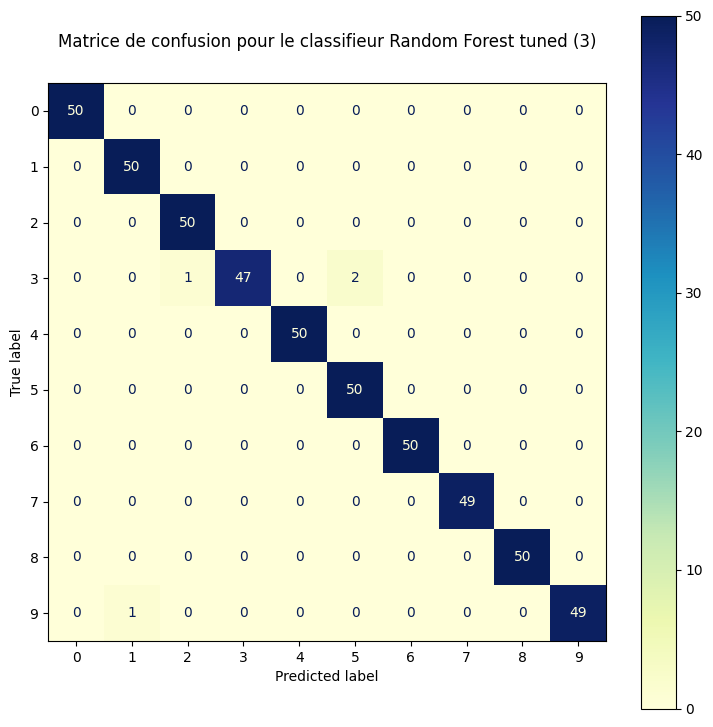

In [28]:
# Matrice de confusion
_, ax = plt.subplots(figsize=(9, 9))

rf_mat_sc = metrics.plot_confusion_matrix(grid_rf2, X_val_sc, y_val_sc, cmap="YlGnBu", ax=ax)
plt.title("Matrice de confusion - Random Forest, données standardisées tuned (3)", y=1.05)
plt.show()

In [29]:
# Importance des variables

# relancer l'algorithme avec les meilleurs paramètres
rf3_best = RandomForestClassifier(max_depth=80, n_estimators=200, random_state=2020).fit(X_train_sc, y_train_sc)

ls_vars = df_train.iloc[:,:-1].columns.to_numpy()

importance = rf3_best.feature_importances_

rf_importance_df = pd.DataFrame({"variable":ls_vars, "importance":importance})
rf_importance_df.sort_values("importance", ascending=False)


,variable,importance
356,mor1,0.02723
361,mor6,0.02496
357,mor2,0.02473
359,mor4,0.01805
360,mor5,0.01497
...,...,...
397,pix_36,0.00005
574,pix_213,0.00005
372,pix_11,0.00004
557,pix_196,0.00002


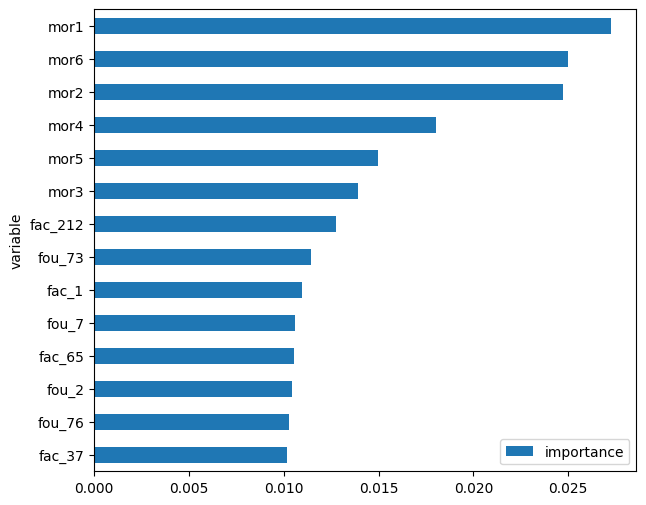

In [30]:
rf_importance_df[rf_importance_df.importance >= 0.01].sort_values("importance", ascending=True).plot.barh("variable","importance", figsize=(7,6))
plt.show()

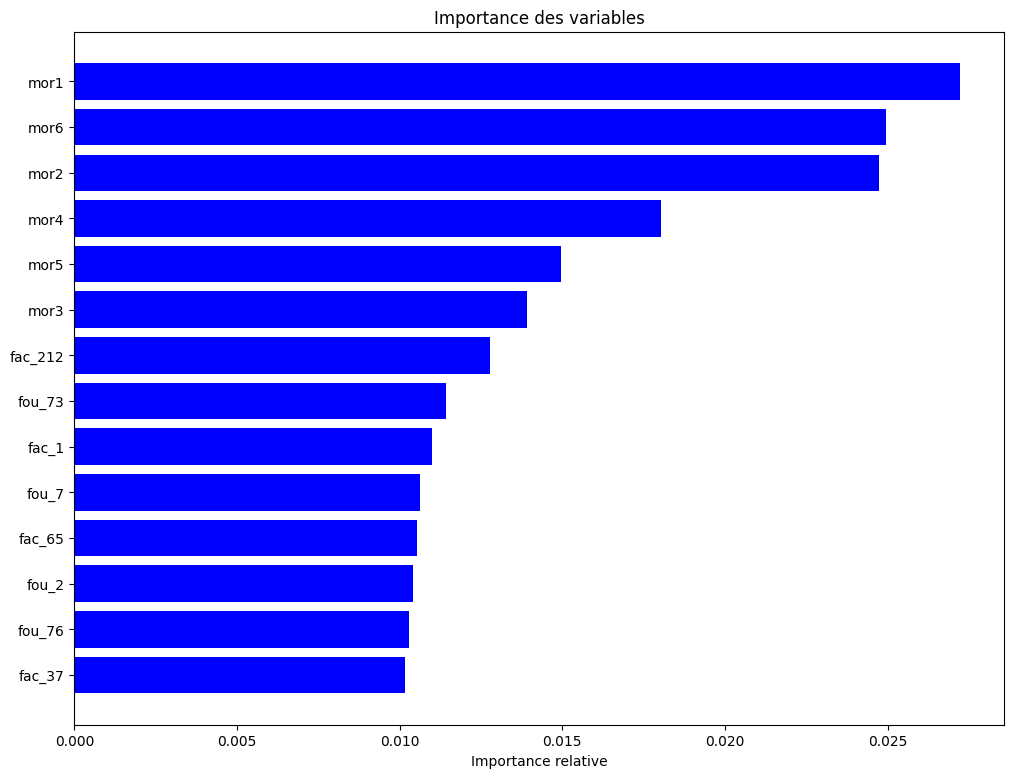

In [31]:
# Importance des variables si >= 0.01

idx = np.argsort(importance)

masque = importance[idx] >= 0.01

plt.figure(figsize=(12,9))
plt.title("Importance des variables")
plt.barh(ls_vars[idx][masque], importance[idx][masque], color='b', align='center')
plt.xlabel("Importance relative")
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.8</span>

Requirements.txt  

```
absl-py==2.1.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0       
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==4.2.4
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.4
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
gast==0.3.3
google-auth==1.35.0
google-auth-oauthlib==0.4.6        
google-pasta==0.2.0
grpcio==1.66.2
h5py==2.10.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==8.5.0
importlib-resources==6.4.5
ipykernel==6.25.2
ipython==8.12.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.1.1
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-client==8.3.1
jupyter-console==6.6.3
jupyter-core==5.3.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter-server==2.7.3
jupyter-server-terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-server==2.25.0
jupyterlab-widgets==3.0.9
Keras==2.4.3
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
Markdown==3.7
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
missingno==0.5.2
mistune==3.0.1
multimethod==1.8
nbclient==0.8.0
nbconvert==7.8.0
nbformat==5.9.2
nest-asyncio==1.5.8
networkx==3.1
notebook==7.0.3
notebook-shim==0.2.3
numpy==1.22.0
oauthlib==3.2.2
opt-einsum==3.4.0
overrides==7.4.0
packaging==23.1
pandas==1.4.0
pandas-profiling==3.3.0
pandocfilters==1.5.0
parso==0.8.3
patsy==0.5.3
pexpect==4.8.0
phik==0.12.3
pickleshare==0.7.5
Pillow==10.0.1
pkgutil-resolve-name==1.3.10
platformdirs==3.10.0
prometheus-client==0.17.1
prompt-toolkit==3.0.39
protobuf==3.20.3
psutil==5.9.5
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.1
pyasn1-modules==0.4.1
pycparser==2.21
pydantic==1.9.2
Pygments==2.16.1
pyparsing==3.1.1
python-dateutil==2.8.2
python-json-logger==2.0.7
pytz==2023.3.post1
PyWavelets==1.4.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==25.1.1
qtconsole==5.4.4
QtPy==2.4.0
referencing==0.30.2
requests==2.28.0
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.10.3
rsa==4.9
scikit-learn==0.23.2
scipy==1.4.1
seaborn==0.11.2
Send2Trash==1.8.2
six==1.16.0
sniffio==1.3.0
soupsieve==2.5
stack-data==0.6.2
statsmodels==0.13.5
tangled-up-in-unicode==0.2.0
tensorboard==2.2.2
tensorboard-plugin-wit==1.8.1
tensorflow==2.2.0
tensorflow-estimator==2.2.0
termcolor==2.4.0
terminado==0.17.1
threadpoolctl==3.5.0
tinycss2==1.2.1
tomli==2.0.1
tornado==6.3.3
tqdm==4.64.1
traitlets==5.10.0
typing-extensions==4.7.1
uri-template==1.3.0
urllib3==1.26.16
visions==0.7.5
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.6.3
werkzeug==3.0.4
widgetsnbextension==4.0.9
wrapt==1.16.0
xlrd==2.0.1
zipp==3.20.2
```